[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14rrWVXvlPyCMtWg6wBA9wcAMm3vP5APx?usp=sharing) for a version with Plotly figures

# SQL with nycflights13 data

'nycflights13' is a relational database with airline on-time data for all flights departing NYC in 2013 as well as related tables of airlines, airports, planes and weather.

In this notebook, I perform an exploratory and descriptive analysis mainly looking into how the departure delay time of each flight is related to other variables. In specific, the following questions are asked:
- Which airlines are dominant at each origin airport?
- Top 10 days with the largest number of flights
- Is the departure delay time varying across airlines?
- What is the relation between the departure delay time and weather factors?


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Connect to the db file in the current directory and list all the tables

conn = sqlite3.connect('nycflights13.db')
q = '''
SELECT * FROM sqlite_master WHERE type='table'
'''
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,airlines,airlines,2,"CREATE TABLE ""airlines"" (\n\t""carrier""\tTEXT,\..."
1,table,airports,airports,5,"CREATE TABLE ""airports"" (\n\t""faa""\tTEXT,\n\t""..."
2,table,flights,flights,13,"CREATE TABLE ""flights"" (\n\t""ID""\tINTEGER,\n\t..."
3,table,planes,planes,602,"CREATE TABLE ""planes"" (\n\t""tailnum""\tTEXT,\n\..."
4,table,weather,weather,6725,"CREATE TABLE ""weather"" (\n\t""field1""\tINTEGER,..."


- List of 16 airlines in the dataset

In [3]:
q = '''
SELECT * FROM airlines
'''
pd.read_sql_query(q, conn)

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.
2,AS,Alaska Airlines Inc.
3,B6,JetBlue Airways
4,DL,Delta Air Lines Inc.
5,EV,ExpressJet Airlines Inc.
6,F9,Frontier Airlines Inc.
7,FL,AirTran Airways Corporation
8,HA,Hawaiian Airlines Inc.
9,MQ,Envoy Air


- 'flights' table with 336,776 filghts in 2013

In [4]:
q = '''
SELECT * FROM flights
'''
pd.read_sql_query(q, conn)

,ID,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,1,2013,1,1,517,515,2,830,819,11,UA,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01 05:00:00
1,2,2013,1,1,533,529,4,850,830,20,UA,1714,N24211,LGA,IAH,227,1416,5,29,2013-01-01 05:00:00
2,3,2013,1,1,542,540,2,923,850,33,AA,1141,N619AA,JFK,MIA,160,1089,5,40,2013-01-01 05:00:00
3,4,2013,1,1,544,545,-1,1004,1022,-18,B6,725,N804JB,JFK,BQN,183,1576,5,45,2013-01-01 05:00:00
4,5,2013,1,1,554,600,-6,812,837,-25,DL,461,N668DN,LGA,ATL,116,762,6,0,2013-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,336772,2013,9,30,NA,1455,NA,NA,1634,NA,9E,3393,NA,JFK,DCA,NA,213,14,55,2013-09-30 14:00:00
336772,336773,2013,9,30,NA,2200,NA,NA,2312,NA,9E,3525,NA,LGA,SYR,NA,198,22,0,2013-09-30 22:00:00
336773,336774,2013,9,30,NA,1210,NA,NA,1330,NA,MQ,3461,N535MQ,LGA,BNA,NA,764,12,10,2013-09-30 12:00:00
336774,336775,2013,9,30,NA,1159,NA,NA,1344,NA,MQ,3572,N511MQ,LGA,CLE,NA,419,11,59,2013-09-30 11:00:00


- Total numbers of flights for three origin airports
- The flights numbers are not biased to one or two origin airports. 

In [5]:
q = '''
SELECT origin, count(*) as countFlights
FROM flights
GROUP BY origin
'''
pd.read_sql_query(q, conn)

,origin,countFlights
0,EWR,120835
1,JFK,111279
2,LGA,104662


## 1. Which airlines are dominant at each origin airport?

#### Departure from EWR
- United Air Lines (UA, 38%) and ExpressJet Airlines (EV, 36%) compose 74.5% of all departures from EWR.

In [6]:
# Number/percentage of flights per airlines when the origin airport is EWR
q = '''
SELECT  f.origin, 
        f.carrier, 
        a.name as airlines_name,
        count(*) as countFlights, 
        round(( cast(COUNT(*) as REAL) / (SELECT count(*) FROM flights WHERE origin = 'EWR') )*100, 2) as pctFlights
FROM flights as f
INNER JOIN airlines as a
ON f.carrier = a.carrier
WHERE origin = 'EWR'
GROUP BY f.carrier 
ORDER BY pctFlights DESC
'''
pd.read_sql_query(q, conn)

,origin,carrier,airlines_name,countFlights,pctFlights
0,EWR,UA,United Air Lines Inc.,46087,38.14
1,EWR,EV,ExpressJet Airlines Inc.,43939,36.36
2,EWR,B6,JetBlue Airways,6557,5.43
3,EWR,WN,Southwest Airlines Co.,6188,5.12
4,EWR,US,US Airways Inc.,4405,3.65
5,EWR,DL,Delta Air Lines Inc.,4342,3.59
6,EWR,AA,American Airlines Inc.,3487,2.89
7,EWR,MQ,Envoy Air,2276,1.88
8,EWR,VX,Virgin America,1566,1.30
9,EWR,9E,Endeavor Air Inc.,1268,1.05


#### Departure from JFK
- JetBlue Airways (B6, 38%) and Delta Air Lines (DL, 19%) compose 56.4% of all departures from JFK.

In [7]:
# Number/percentage of flights per airlines when the origin airport is JFK
q = '''
SELECT  f.origin, 
        f.carrier, 
        a.name as airlines_name,
        count(*) as countFlights, 
        round(( cast(COUNT(*) as REAL) / (SELECT count(*) FROM flights WHERE origin = 'JFK') )*100, 2) as pctFlights
FROM flights as f
INNER JOIN airlines as a
ON f.carrier = a.carrier
WHERE origin = 'JFK'
GROUP BY f.carrier 
ORDER BY pctFlights DESC
'''
pd.read_sql_query(q, conn)

,origin,carrier,airlines_name,countFlights,pctFlights
0,JFK,B6,JetBlue Airways,42076,37.81
1,JFK,DL,Delta Air Lines Inc.,20701,18.60
2,JFK,9E,Endeavor Air Inc.,14651,13.17
3,JFK,AA,American Airlines Inc.,13783,12.39
4,JFK,MQ,Envoy Air,7193,6.46
5,JFK,UA,United Air Lines Inc.,4534,4.07
6,JFK,VX,Virgin America,3596,3.23
7,JFK,US,US Airways Inc.,2995,2.69
8,JFK,EV,ExpressJet Airlines Inc.,1408,1.27
9,JFK,HA,Hawaiian Airlines Inc.,342,0.31


#### Departure from LGA
- Delta Air Lines (DL), Envoy Air (MQ), American Airlines (AA) compose 53.0% of all departures from LGA.

In [8]:
# Number/percentage of flights per airlines when the origin airport is LGA
q = '''
SELECT  f.origin, 
        f.carrier, 
        a.name as airlines_name,
        count(*) as countFlights, 
        round(( cast(COUNT(*) as REAL) / (SELECT count(*) FROM flights WHERE origin = 'LGA') )*100, 2) as pctFlights
FROM flights as f
INNER JOIN airlines as a
ON f.carrier = a.carrier
WHERE origin = 'LGA'
GROUP BY f.carrier 
ORDER BY pctFlights DESC
'''
pd.read_sql_query(q, conn)

,origin,carrier,airlines_name,countFlights,pctFlights
0,LGA,DL,Delta Air Lines Inc.,23067,22.04
1,LGA,MQ,Envoy Air,16928,16.17
2,LGA,AA,American Airlines Inc.,15459,14.77
3,LGA,US,US Airways Inc.,13136,12.55
4,LGA,EV,ExpressJet Airlines Inc.,8826,8.43
5,LGA,UA,United Air Lines Inc.,8044,7.69
6,LGA,WN,Southwest Airlines Co.,6087,5.82
7,LGA,B6,JetBlue Airways,6002,5.73
8,LGA,FL,AirTran Airways Corporation,3260,3.11
9,LGA,9E,Endeavor Air Inc.,2541,2.43


## 2. Top 10 days with the largest number of flights

- The busiest days in 2013 include 11/27/2013 (the end of Thanksgiving) and 12/2/2013 (beginning of December). The others are in July. 

In [9]:
q = '''
SELECT  year, month, day, 
        case cast (strftime('%w', time_hour) as integer)
        when 0 then 'Sunday'
        when 1 then 'Monday'
        when 2 then 'Tuesday'
        when 3 then 'Wednesday'
        when 4 then 'Thursday'
        when 5 then 'Friday'
        else 'Saturday' 
        end as dayofweek, 
        count(*) as countFlights
FROM flights 
GROUP BY month, day
ORDER BY countFlights DESC
LIMIT 10
'''
pd.read_sql_query(q, conn)

,year,month,day,dayofweek,countFlights
0,2013,11,27,Wednesday,1014
1,2013,7,11,Thursday,1006
2,2013,7,8,Monday,1004
3,2013,7,10,Wednesday,1004
4,2013,12,2,Monday,1004
5,2013,7,18,Thursday,1003
6,2013,7,25,Thursday,1003
7,2013,7,12,Friday,1002
8,2013,7,9,Tuesday,1001
9,2013,7,17,Wednesday,1001


## 3. Is the departure delay time varying across airlines?

- Averaged departure delay times (min) per airline are quite different across airlines.
- The airlines with the shortest delay time are US (3.7 m), HA (4.9 m), AS (5.8 m) and AA (8.4 m).
- The airlines with the longest delay time are F9 (20.1 m), EV (18.9 m), FL (18.3 m), whereas the overall average time is 12.3 m.

In [10]:
# Average departure delays per airline, 
# where dep_delay can be negative to indicate early departure.
q = '''
SELECT  carrier, 
        count(*) as countFlights,
        round(avg(dep_delay), 1) as avg_dep_delay,
        round((SELECT avg(dep_delay) FROM flights), 1) as overall_avg_delp_delay
FROM flights
GROUP BY carrier
ORDER BY avg_dep_delay
'''
pd.read_sql_query(q, conn)

,carrier,countFlights,avg_dep_delay,overall_avg_delp_delay
0,US,20536,3.7,12.3
1,HA,342,4.9,12.3
2,AS,714,5.8,12.3
3,AA,32729,8.4,12.3
4,DL,48110,9.2,12.3
5,MQ,26397,10.1,12.3
6,OO,32,11.4,12.3
7,UA,58665,12.0,12.3
8,VX,5162,12.8,12.3
9,B6,54635,12.9,12.3


## 4. What is the relation between the departure delay time and weather factors?

- Join the flights and weather table.

In [11]:
q = '''
SELECT  f.month, f.day, f.hour, f.dep_time, f.dep_delay, f.origin, f.dest, f.arr_delay, f.time_hour,
        w.wind_speed, w.wind_gust, w.precip, w.visib, w.time_hour
FROM flights as f
LEFT JOIN weather as w
ON f.time_hour = w.time_hour and f.origin = w.origin 
'''
df0 = pd.read_sql_query(q, conn)
df0

,month,day,hour,dep_time,dep_delay,origin,dest,arr_delay,time_hour,wind_speed,wind_gust,precip,visib,time_hour
0,1,1,5,517,2,EWR,IAH,11,2013-01-01 05:00:00,12.65858,NaN,0.0,10.0,2013-01-01 05:00:00
1,1,1,5,533,4,LGA,IAH,20,2013-01-01 05:00:00,14.96014,21.86482,0.0,10.0,2013-01-01 05:00:00
2,1,1,5,542,2,JFK,MIA,33,2013-01-01 05:00:00,14.96014,NaN,0.0,10.0,2013-01-01 05:00:00
3,1,1,5,544,-1,JFK,BQN,-18,2013-01-01 05:00:00,14.96014,NaN,0.0,10.0,2013-01-01 05:00:00
4,1,1,6,554,-6,LGA,ATL,-25,2013-01-01 06:00:00,16.11092,23.01560,0.0,10.0,2013-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336771,9,30,14,NA,NA,JFK,DCA,NA,2013-09-30 14:00:00,11.5078,NaN,0.0,10.0,2013-09-30 14:00:00
336772,9,30,22,NA,NA,LGA,SYR,NA,2013-09-30 22:00:00,6.90468,NaN,0.0,10.0,2013-09-30 22:00:00
336773,9,30,12,NA,NA,LGA,BNA,NA,2013-09-30 12:00:00,5.7539,NaN,0.0,10.0,2013-09-30 12:00:00
336774,9,30,11,NA,NA,LGA,CLE,NA,2013-09-30 11:00:00,8.05546,NaN,0.0,10.0,2013-09-30 11:00:00


### Average departure delay vs visibility in miles at the origin airport

In [12]:
# avgDepDelay (min) vs visib
q = '''
SELECT  round(w.visib, 0) as visibility,
        avg(dep_delay) as avg_dep_delay, 
        count(*) as countFlights
FROM flights as f
LEFT JOIN weather as w
ON f.time_hour = w.time_hour and f.origin = w.origin 
GROUP BY visibility
ORDER BY visibility
'''
avgDepDelay_visib = pd.read_sql_query(q, conn)
avgDepDelay_visib

,visibility,avg_dep_delay,countFlights
0,NaN,13.185090,1556
1,0.0,25.831584,2001
2,1.0,29.763129,3656
3,2.0,22.147018,5047
4,3.0,19.802740,6058
5,4.0,18.436751,2253
6,5.0,20.024329,4809
7,6.0,18.807188,6260
8,7.0,18.317408,7347
9,8.0,19.199107,7614


- *Departure delay* increases as *visibility* gets lower with mild non-linearity. 

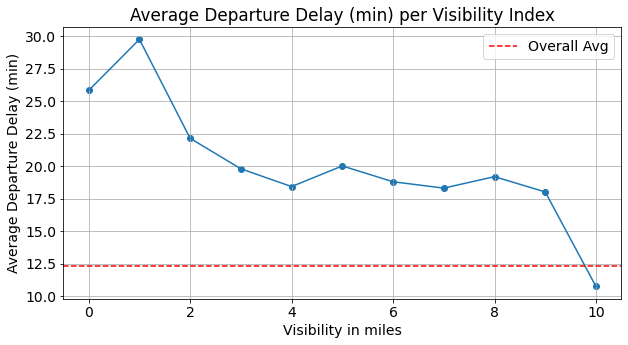

In [69]:
avgDepDelay_visib1 = avgDepDelay_visib[~pd.isna(avgDepDelay_visib['visibility'])]
x = avgDepDelay_visib1['visibility']
y = avgDepDelay_visib1['avg_dep_delay']

# setting font size  
plt.rcParams.update({'font.size': 14})
 
fig = plt.figure(figsize=(10,5))

plt.plot(x, y)
plt.scatter(x, y)
plt.xlabel('Visibility in miles')
plt.ylabel('Average Departure Delay (min)')
plt.title('Average Departure Delay (min) per Visibility Index')

# Draw a refline 
avgDep = pd.read_sql_query('SELECT avg(dep_delay) as avg FROM flights', conn)
avgDep1 = avgDep['avg'][0]
plt.axhline(y = avgDep1, color = 'r', linestyle = '--', label='Overall Avg')
plt.legend()
plt.grid()

### Average departure delay vs wind speed (mph)

In [66]:
# avgDepDelay (min) vs wind_speed (mph)
q = '''
SELECT  round(w.wind_speed / 5, 0) * 5 as wind_speed_cat,
        avg(dep_delay) as avg_dep_delay, 
        count(*) as countFlights
FROM flights as f
LEFT JOIN weather as w
ON f.time_hour = w.time_hour and f.origin = w.origin 
GROUP BY wind_speed_cat
ORDER BY wind_speed_cat
'''
avgDepDelay_windSpeed = pd.read_sql_query(q, conn)
avgDepDelay_windSpeed

,wind_speed_cat,avg_dep_delay,countFlights
0,NaN,13.185090,1556
1,0.0,9.803059,11963
2,5.0,10.141716,77867
3,10.0,11.898753,114453
4,15.0,13.834633,92443
5,20.0,14.266667,27345
6,25.0,16.790280,7963
7,30.0,17.909930,2709
8,35.0,25.977444,399
9,40.0,18.595745,47


- *Departure delay* increases as *wind speed* gets higher in most cases, but the delay time declines in a tiny portion of extreme cases when *wind speed* exceeds ~37.5 mph.

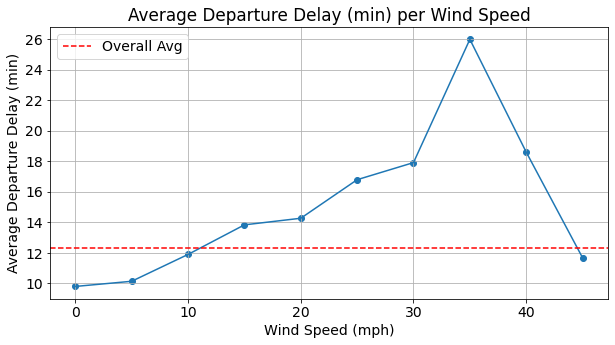

In [68]:
avgDepDelay_windSpeed1 = avgDepDelay_windSpeed[~pd.isna(avgDepDelay_windSpeed['wind_speed_cat'])]
x = avgDepDelay_windSpeed1['wind_speed_cat']
y = avgDepDelay_windSpeed1['avg_dep_delay']

# setting font size  
plt.rcParams.update({'font.size': 14})
 
fig = plt.figure(figsize=(10,5))

plt.plot(x, y)
plt.scatter(x, y)
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Average Departure Delay (min)')
plt.title('Average Departure Delay (min) per Wind Speed')

# Draw a refline 
avgDep = pd.read_sql_query('SELECT avg(dep_delay) as avg FROM flights', conn)
avgDep1 = avgDep['avg'][0]
plt.axhline(y = avgDep1, color = 'r', linestyle = '--', label='Overall Avg')
plt.legend()
plt.grid()

In [70]:
# Close the db connection
conn.close()